In [1]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from transformers import BertTokenizerFast
import matplotlib.pyplot as plt

/home/kevin/miniconda3/envs/news_aggregator_pytorch/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df_true = pd.read_csv("True.csv")
df_fake = pd.read_csv("Fake.csv")
df_true_rep=[df_true['text'][i].replace('WASHINGTON (Reuters) - ','').replace('LONDON (Reuters) - ','').replace('(Reuters) - ','') for i in range(len(df_true['text']))]
df_true['text']=df_true_rep

df_true["label"] = [1 for _ in range(len((df_true)))]
df_fake["label"] = [0 for _ in range(len((df_fake)))]

df = pd.concat([df_fake, df_true])
df = df.sample(frac=1).reset_index(drop=True)

In [3]:
# Keep only text and label columns
df = df[['text', 'label']]


In [4]:
# Basic preprocessing
def preprocess(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    return text

# Apply preprocessing
df['text'] = df['text'].apply(preprocess)

In [20]:
# Initialize Hugging Face tokenizer and stop words
hf_tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')
stop_words = set(ENGLISH_STOP_WORDS)

# Tokenization and encoding functions using HF tokenizer + stopword filtering
def tokenize(text):
    tokens = hf_tokenizer.tokenize(text)
    return [tok for tok in tokens if tok not in stop_words]

def encode(text):
    ids = hf_tokenizer.convert_tokens_to_ids(tokenize(text))
    # ensure non-empty sequence for packing
    if len(ids) == 0:
        return [hf_tokenizer.unk_token_id]
    return ids

# Apply encoding
df['encoded'] = df['text'].apply(encode)

Token indices sequence length is longer than the specified maximum sequence length for this model (1063 > 512). Running this sequence through the model will result in indexing errors


In [21]:
# Split into train / val / test
train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, stratify=temp_df['label'])

In [22]:
# Dataset and DataLoader with padding
class NewsDataset(Dataset):
    def __init__(self, df):
        self.encodings = df['encoded'].tolist()
        self.labels = df['label'].tolist()
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        return torch.tensor(self.encodings[idx], dtype=torch.long), torch.tensor(self.labels[idx], dtype=torch.long)

def collate_batch(batch):
    texts, labels = zip(*batch)
    lengths = torch.tensor([len(x) for x in texts], dtype=torch.long)
    padded = pad_sequence(texts, batch_first=True, padding_value=hf_tokenizer.pad_token_id)
    labels = torch.stack(labels)
    return padded, lengths, labels

batch_size = 64
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_loader = DataLoader(NewsDataset(train_df), batch_size=batch_size, shuffle=True, collate_fn=collate_batch)
val_loader   = DataLoader(NewsDataset(val_df),   batch_size=batch_size, shuffle=False, collate_fn=collate_batch)
test_loader  = DataLoader(NewsDataset(test_df),  batch_size=batch_size, shuffle=False, collate_fn=collate_batch)


In [23]:
# Define RNN Model
class RNNClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim, num_layers=1, bidirectional=False, dropout=0.5):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=hf_tokenizer.pad_token_id)
        self.rnn = nn.LSTM(embed_dim, hidden_dim, num_layers=num_layers, batch_first=True,
                           bidirectional=bidirectional, dropout=dropout if num_layers>1 else 0)
        factor = 2 if bidirectional else 1
        self.fc = nn.Linear(hidden_dim * factor, output_dim)
        self.dropout = nn.Dropout(dropout)
    def forward(self, text, lengths):
        embedded = self.dropout(self.embedding(text))
        packed = nn.utils.rnn.pack_padded_sequence(embedded, lengths.cpu(), batch_first=True, enforce_sorted=False)
        _, (hidden, _) = self.rnn(packed)
        if self.rnn.bidirectional:
            hidden = torch.cat((hidden[-2], hidden[-1]), dim=1)
        else:
            hidden = hidden[-1]
        return self.fc(self.dropout(hidden))

model = RNNClassifier(vocab_size=hf_tokenizer.vocab_size, embed_dim=100, hidden_dim=128,
                      output_dim=2, num_layers=2, bidirectional=True, dropout=0.5).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [24]:
# Training & evaluation functions
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    total_loss, correct, count = 0, 0, 0
    for texts, lengths, labels in loader:
        texts, lengths, labels = texts.to(device), lengths.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(texts, lengths)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * labels.size(0)
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        count += labels.size(0)
    return total_loss/count, correct/count

def eval_epoch(model, loader, criterion, device):
    model.eval()
    total_loss, correct, count = 0, 0, 0
    with torch.no_grad():
        for texts, lengths, labels in loader:
            texts, lengths, labels = texts.to(device), lengths.to(device), labels.to(device)
            outputs = model(texts, lengths)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * labels.size(0)
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            count += labels.size(0)
    return total_loss/count, correct/count

In [25]:
# Training loop
n_epochs = 10
train_losses, val_losses, train_accs, val_accs = [], [], [], []
for epoch in range(1, n_epochs+1):
    t_loss, t_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    v_loss, v_acc = eval_epoch(model, val_loader, criterion, device)
    train_losses.append(t_loss); val_losses.append(v_loss)
    train_accs.append(t_acc); val_accs.append(v_acc)
    print(f"Epoch {epoch}: Train Loss: {t_loss:.4f}, Train Acc: {t_acc:.4f} | Val Loss: {v_loss:.4f}, Val Acc: {v_acc:.4f}")

Epoch 1: Train Loss: 0.2387, Train Acc: 0.8953 | Val Loss: 0.1292, Val Acc: 0.9537
Epoch 2: Train Loss: 0.0976, Train Acc: 0.9641 | Val Loss: 0.0512, Val Acc: 0.9815
Epoch 3: Train Loss: 0.0572, Train Acc: 0.9794 | Val Loss: 0.0470, Val Acc: 0.9860
Epoch 4: Train Loss: 0.0415, Train Acc: 0.9851 | Val Loss: 0.0363, Val Acc: 0.9871
Epoch 5: Train Loss: 0.0295, Train Acc: 0.9900 | Val Loss: 0.0625, Val Acc: 0.9802
Epoch 6: Train Loss: 0.0458, Train Acc: 0.9853 | Val Loss: 0.0429, Val Acc: 0.9864
Epoch 7: Train Loss: 0.0295, Train Acc: 0.9902 | Val Loss: 0.0286, Val Acc: 0.9922
Epoch 8: Train Loss: 0.0183, Train Acc: 0.9943 | Val Loss: 0.0260, Val Acc: 0.9938
Epoch 9: Train Loss: 0.0152, Train Acc: 0.9954 | Val Loss: 0.0214, Val Acc: 0.9947
Epoch 10: Train Loss: 0.0156, Train Acc: 0.9949 | Val Loss: 0.1148, Val Acc: 0.9717


In [26]:
# Save model and tokenizer
torch.save(model.state_dict(), 'models/fake_news_rnn_model.pth')
print('Model saved: models/fake_news_rnn_model.pth')
hf_tokenizer.save_pretrained('./models/tokenizer/')
print('Tokenizer saved to ./models/tokenizer/')

Model saved: models/fake_news_rnn_model.pth
Tokenizer saved to ./models/tokenizer/


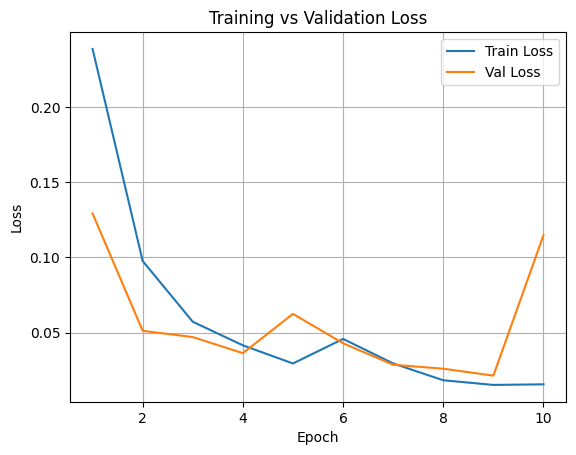

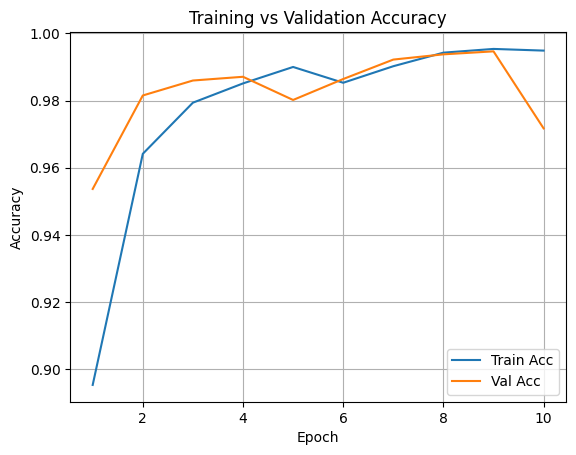

In [29]:
# Plot Loss
plt.figure()
plt.plot(range(1, n_epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, n_epochs+1), val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.title('Training vs Validation Loss')
plt.show()

# Plot Accuracy
plt.figure()
plt.plot(range(1, n_epochs+1), train_accs, label='Train Acc')
plt.plot(range(1, n_epochs+1), val_accs, label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.title('Training vs Validation Accuracy')
plt.show()

In [28]:
# Test set evaluation
all_preds, all_labels = [], []
model.eval()
with torch.no_grad():
    for texts, lengths, labels in test_loader:
        texts, lengths = texts.to(device), lengths.to(device)
        outputs = model(texts, lengths)
        preds = outputs.argmax(1)
        all_preds.extend(preds.cpu().tolist())
        all_labels.extend(labels.tolist())

print('Classification Report:\n', classification_report(all_labels, all_preds))
print('Confusion Matrix:\n', confusion_matrix(all_labels, all_preds))

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.94      0.97      2348
           1       0.94      1.00      0.97      2142

    accuracy                           0.97      4490
   macro avg       0.97      0.97      0.97      4490
weighted avg       0.97      0.97      0.97      4490

Confusion Matrix:
 [[2208  140]
 [   1 2141]]


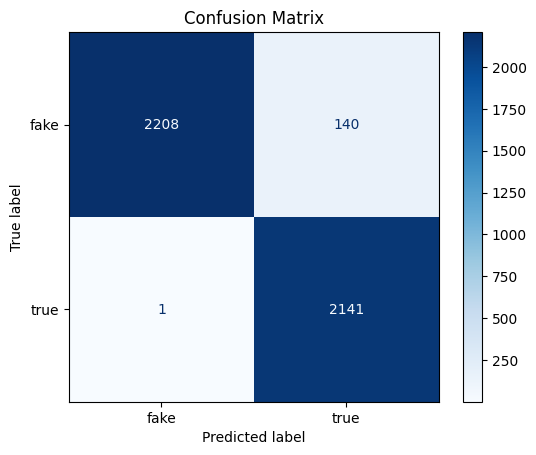

In [33]:
# Compute and plot confusion matrix\ ncm = confusion_matrix(all_labels, all_preds)
cm = confusion_matrix(all_labels, all_preds)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["fake", "true"])
cm_display.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


In [4]:
from fn_detector import FakeNewsDetector
detector = FakeNewsDetector()

In [ ]:
print(detector.predict(df["text"][0]))

1.0
{'prediction': 1, 'confidence': 100.0}


In [3]:
from sentiment import find_sentiment

In [49]:
find_sentiment(df["text"][0], "subjectivity", content=True)

0.11744022503516169
[0.11744022503516169]
1


'Fairly Subjective'